# 3D Image Segmentation
Image segmentation in 3D is challenging for several reasons: In many microscopy imaging techniques, image quality varies in space: For example intensity and/or contrast degrades the deeper you image inside a sample. Furthermore, touching nuclei are hard to differentiate in an automated way. Last but not least, anisotropy is difficult to handle depending on the applied algorithms and respective given parameters. Some algorithms, like the [Voronoi-Otsu-Labeling](https://github.com/clEsperanto/pyclesperanto_prototype/blob/master/demo/segmentation/voronoi_otsu_labeling.ipynb) approach demonstrated here, only work for isotropic data.

In [1]:
from skimage.io import imread
from pyclesperanto_prototype import imshow
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt

import napari
from napari.utils import nbscreenshot

# For 3D processing, powerful graphics processing units might be necessary
# Here we select a GTX or RTX graphics card if available. If none is available
# the following code might still work, but it may be a bit slow
cle.select_device('TX')

C:\Users\Tobias\miniforge3\envs\my_first_env\lib\site-packages\pyclesperanto_prototype\_tier0\_device.py:77: UserWarning: No OpenCL device found with TX in their name. Using Intel(R) UHD Graphics 615 instead.
  warnings.warn(f"No OpenCL device found with {name} in their name. Using {device.name} instead.")


<Intel(R) UHD Graphics 615 on Platform: Intel(R) OpenCL HD Graphics (1 refs)>

To demonstrate the workflow, we're using cropped and resampled image data from the [Broad Bio Image Challenge](https://bbbc.broadinstitute.org/BBBC032):
Ljosa V, Sokolnicki KL, Carpenter AE (2012). Annotated high-throughput microscopy image sets for validation. Nature Methods 9(7):637 / doi. PMID: 22743765 PMCID: PMC3627348. Available at http://dx.doi.org/10.1038/nmeth.2083

In [2]:
input_image = imread("data/BMP4blastocystC3-cropped_resampled_8bit.tif")

voxel_size_x = 0.202
voxel_size_y = 0.202
voxel_size_z = 1

For visualisation purposes we show intensity projections along X, Y and Z.

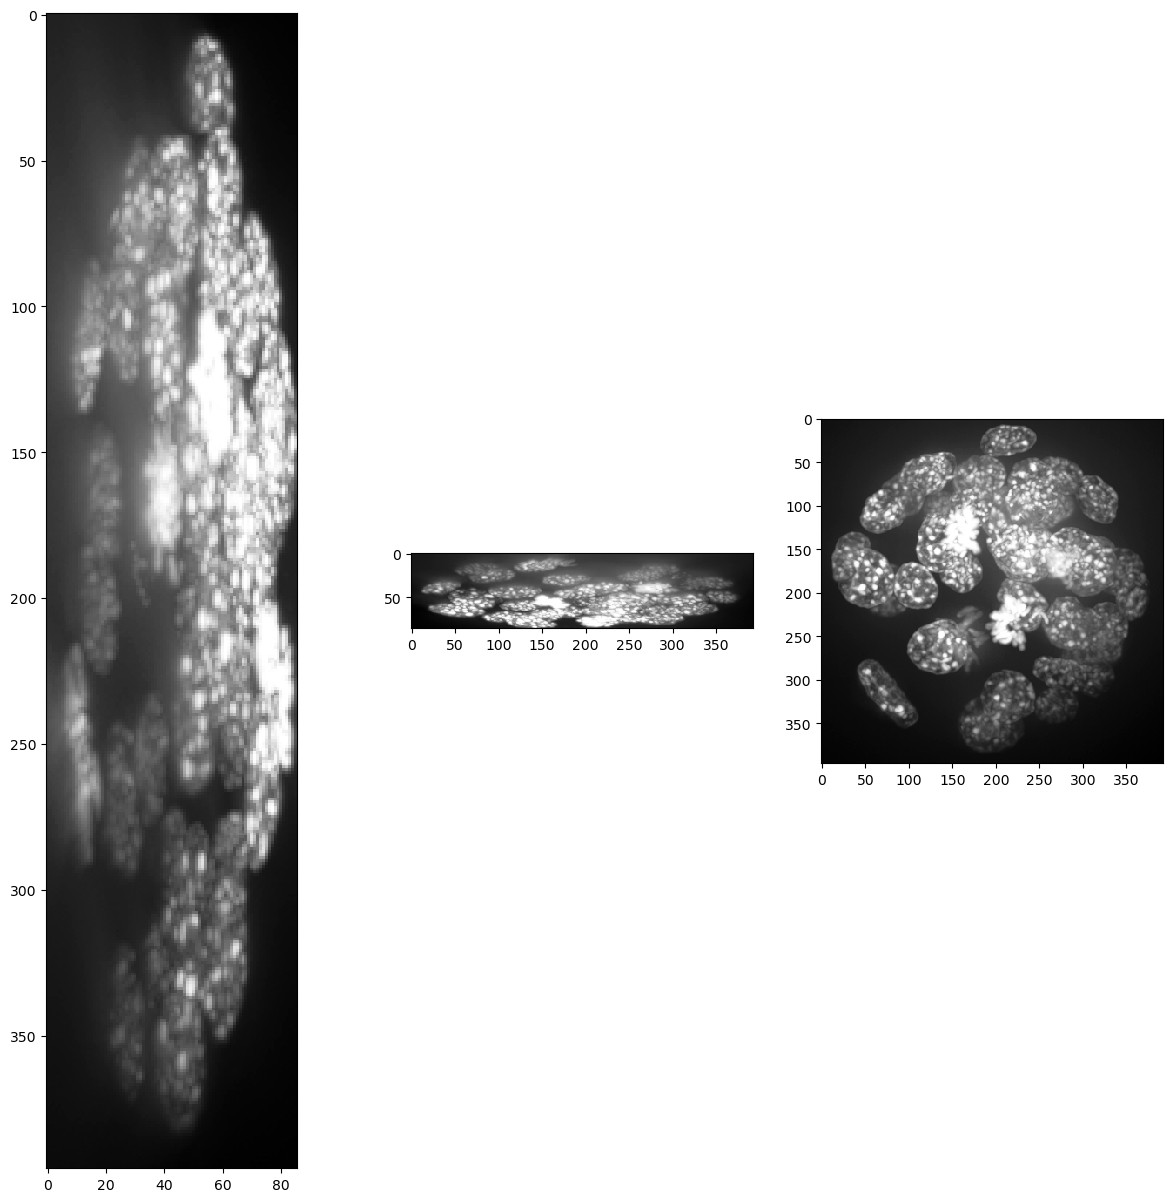

(86, 396, 393)


In [3]:
def show(image_to_show, labels=False):
    """
    This function generates three projections: in X-, Y- and Z-direction and shows them.
    """
    projection_x = cle.maximum_x_projection(image_to_show)
    projection_y = cle.maximum_y_projection(image_to_show)
    projection_z = cle.maximum_z_projection(image_to_show)

    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    cle.imshow(projection_x, plot=axs[0], labels=labels)
    cle.imshow(projection_y, plot=axs[1], labels=labels)
    cle.imshow(projection_z, plot=axs[2], labels=labels)
    plt.show()

show(input_image)
print(input_image.shape)

Obviously, voxel size is not isotropic. Thus, we scale the image with the voxel size used as scaling factor to get an image stack with isotropic voxels.

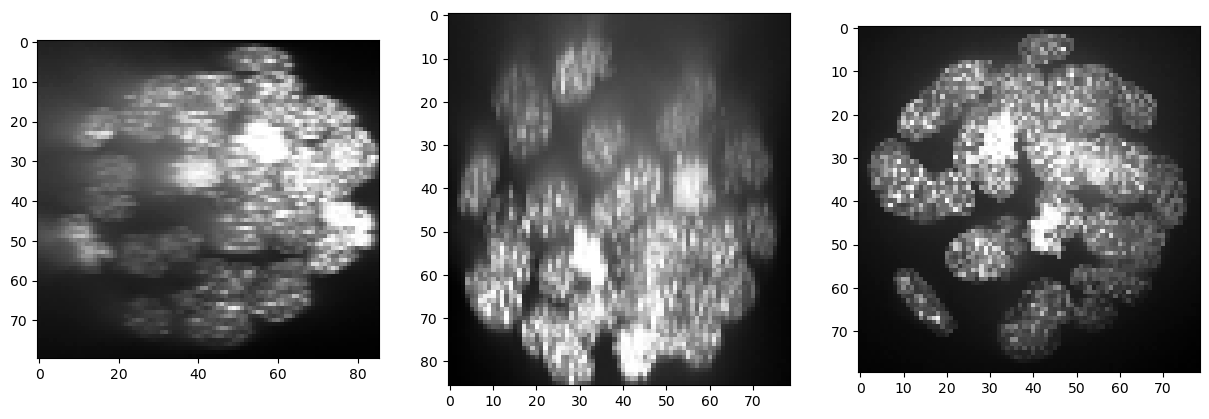

(86, 80, 79)


In [4]:
resampled = cle.scale(input_image, 
                      factor_x=voxel_size_x, 
                      factor_y=voxel_size_y, 
                      factor_z=voxel_size_z, 
                      auto_size=True)

show(resampled)
print(resampled.shape)

## Background correction
As there is background intensity between the nuclei, we remove it using a [top-hat filter](https://en.wikipedia.org/wiki/Top-hat_transform).

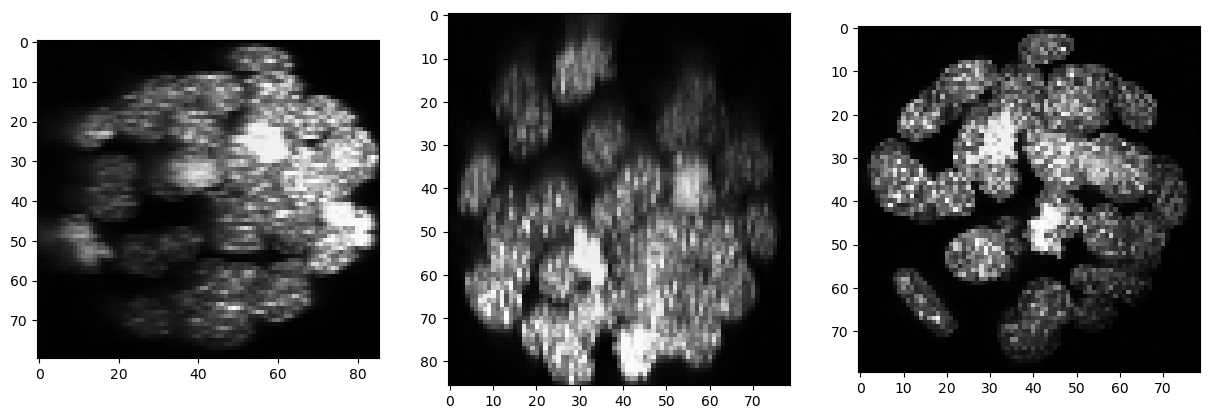

In [5]:
backgrund_subtracted = cle.top_hat_box(resampled, radius_x=5, radius_y=5, radius_z=5)
show(backgrund_subtracted)

## Segmentation
For segmenting the nuclei in 3D we use the Voronoi-Otsu-Labeling technique we have seen earlier. The algorithm works in 3D as in 2D, but only with isotropic voxels. Thanks to the rescaling applied above, our data is isotropic.

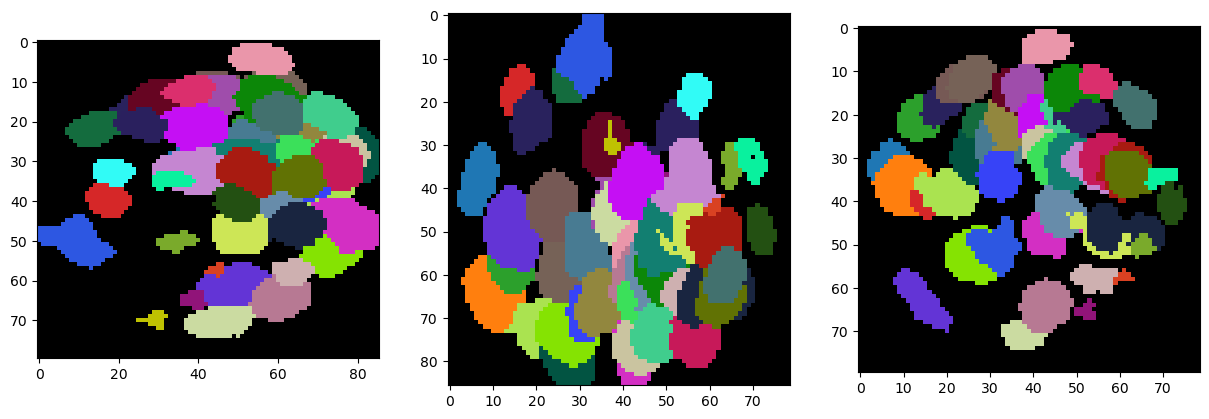

In [6]:
segmented = cle.voronoi_otsu_labeling(backgrund_subtracted, spot_sigma=3, outline_sigma=1)
show(segmented, labels=True)

## Visualization in 3D
For visualization in 3D you can use [napari](https://napari.org/).

In [7]:
# start napari
viewer = napari.Viewer()

# show images
viewer.add_image(cle.pull(resampled))
viewer.add_image(cle.pull(backgrund_subtracted))
viewer.add_labels(cle.pull(segmented))

<Labels layer 'Labels' at 0x21798e44fa0>

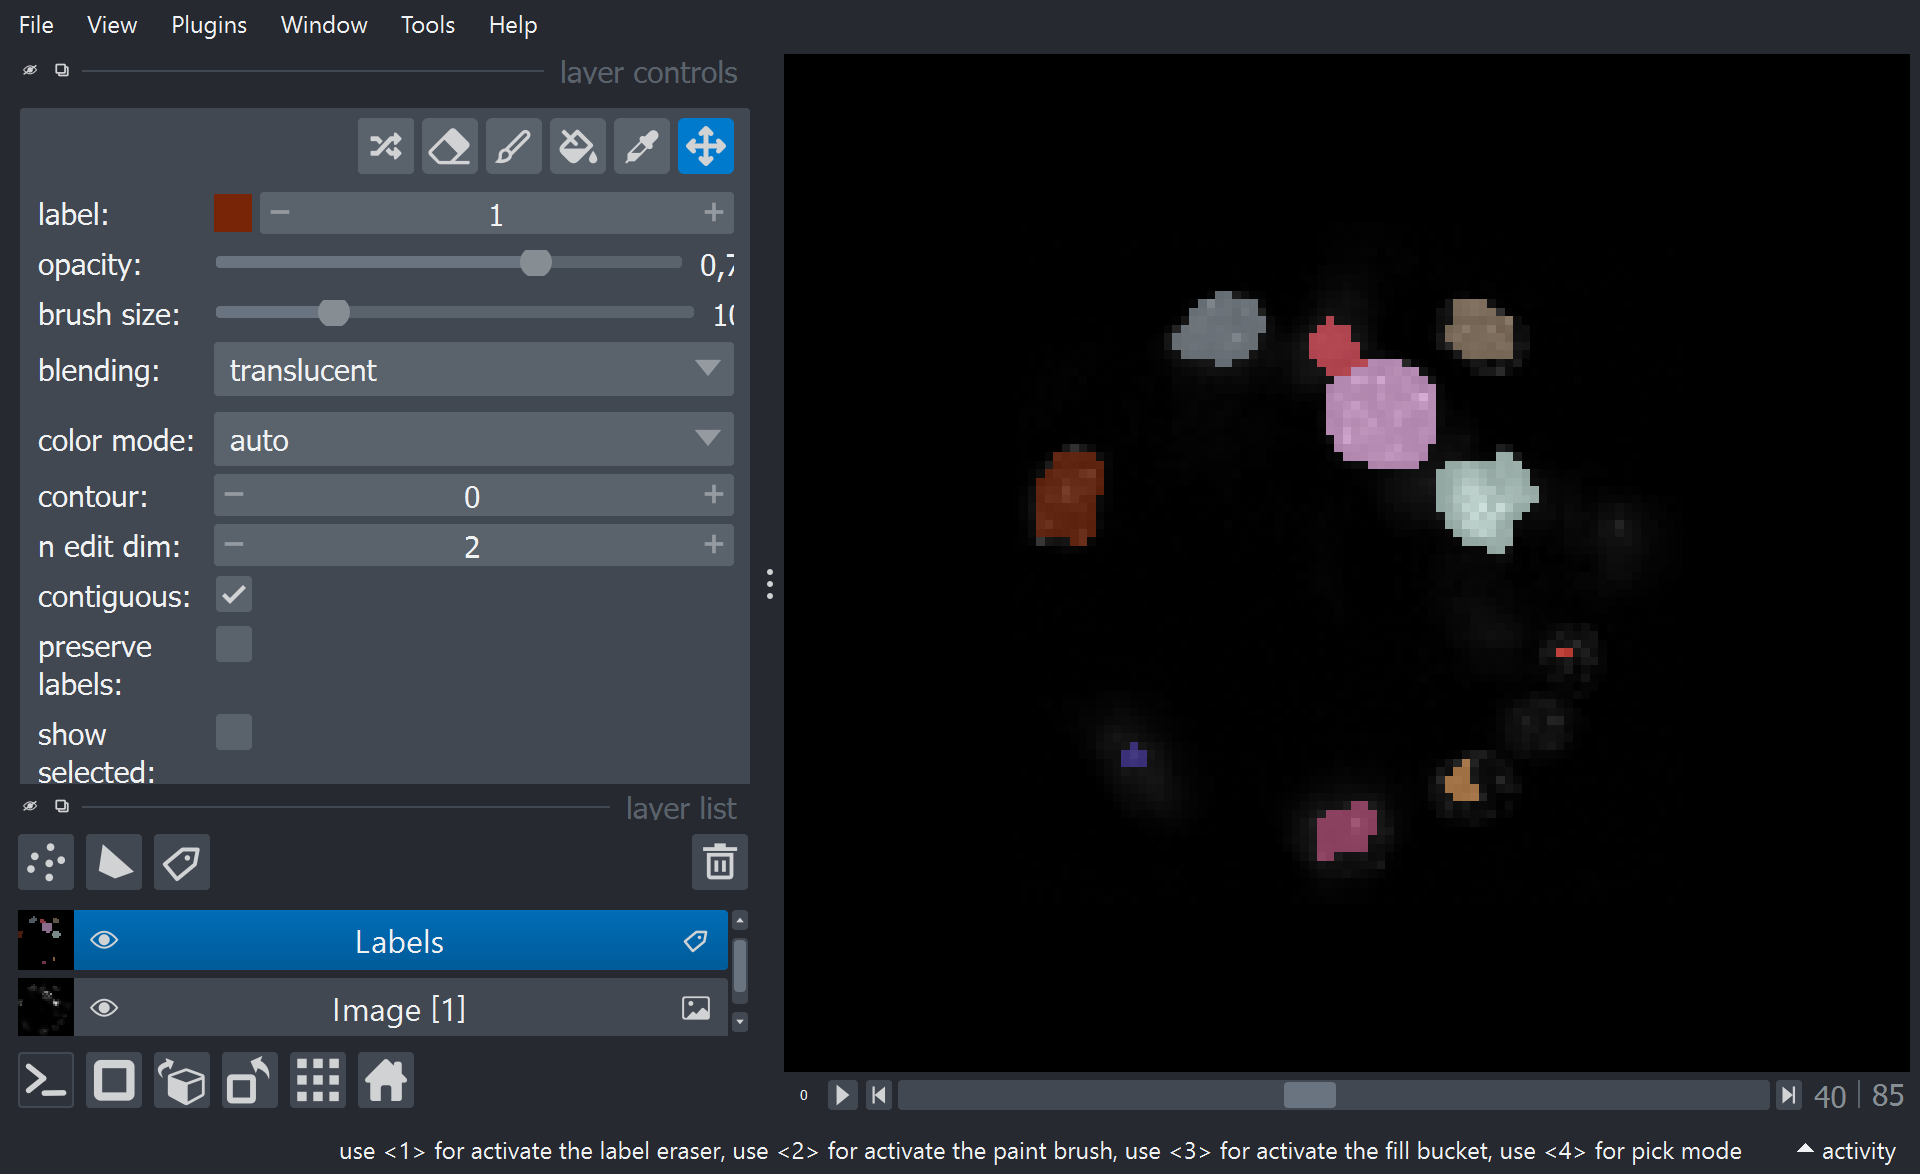

In [8]:
viewer.dims.current_step = (40, 0, 0)
nbscreenshot(viewer)

We can switch to a 3D view by clicking on the 3D button in the bottom left corner.

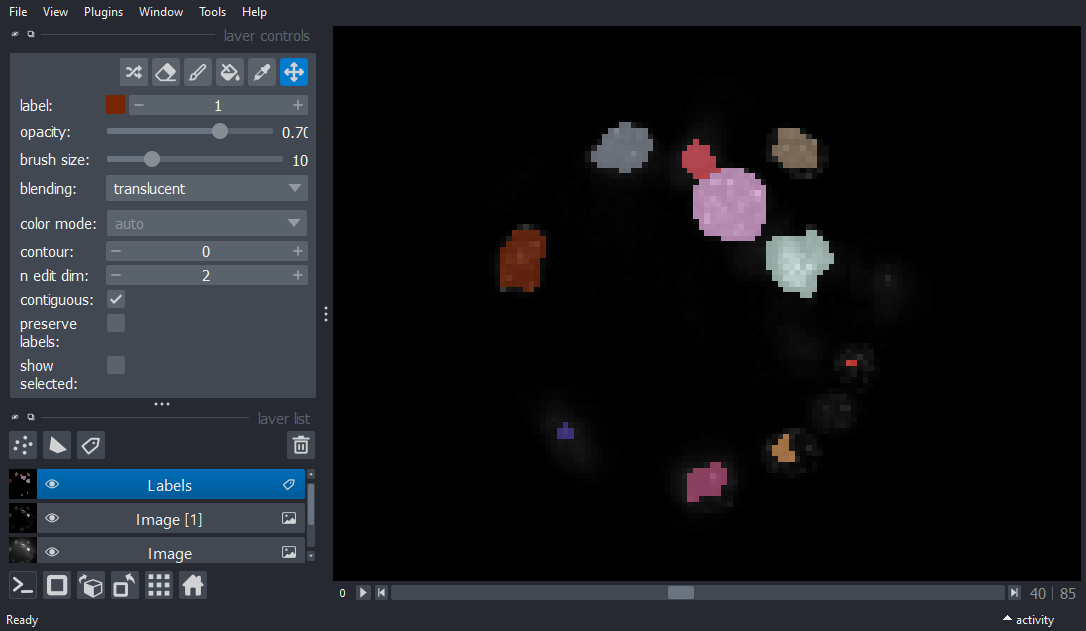

In [9]:
nbscreenshot(viewer)

We can then also tip and tilt the view.

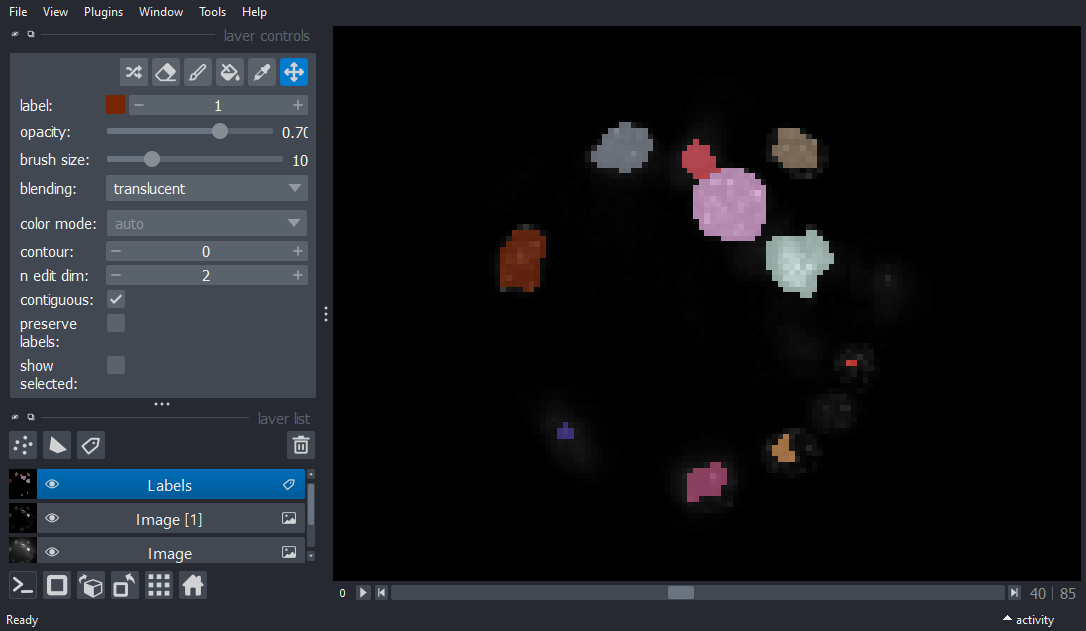

In [10]:
nbscreenshot(viewer)

## Exercise
Load the [skimage.data.cells3d](https://scikit-image.org/docs/stable/api/skimage.data.html#skimage.data.cells3d) dataset, extract the nuclei channel and segment the nuclei. Print out the number of nuclei, which do not touch the image border.

In [40]:
from skimage import data
import napari_segment_blobs_and_things_with_membranes as nsbatwm

# Generiere den 3D-Zelldatensatz
cells_3d = data.cells3d()

In [17]:
viewer = napari.Viewer()

In [18]:
viewer.add_image(cells_3d)

<Image layer 'cells_3d' at 0x2179cb8b580>

In [36]:
cells = cells_3d[:,1,:,:]

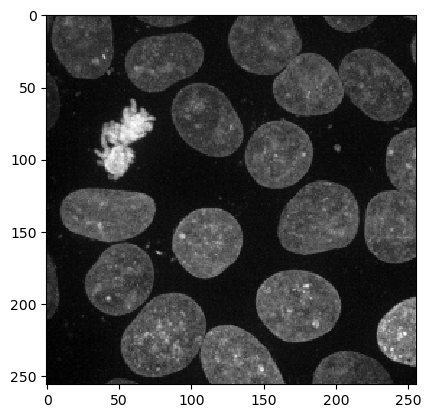

In [35]:
imshow(cells_3d[:,1,:,:])

In [41]:
segmented = nsbatwm.gauss_otsu_labeling(cells)

In [46]:
without_border = nsbatwm.remove_labels_on_edges(segmented)

In [44]:
import stackview

In [47]:
stackview.slice(without_border)

In [48]:
without_border.max()

StackViewNDArray(7)

File cells_3d exists: False
File Result of gauss_otsu_labeling exists: False
File cells_3d exists: False
File Result of remove_labels_on_edges exists: False
File Result of gauss_otsu_labeling exists: False
